In [1]:
# Jupyter Notebook: Reserves Required Analysis in Sports Betting

# Import necessary libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from collections import Counter

# Set display options
%matplotlib inline


Introduction

We have already explored how to hedge a single bet and the reserves required to make a potential payout. However in taking multiple parlay bets on the same events we may be able to hedge even more and reduce the reserves required. Since the events used in parlays are limited, as more parlays are made, some will have combinations that may not possibly all come true. As such the entire positon can be hedged instead of hedging every bet individually. 

In this notebook, we will explore how to:

* combine all positions and determine which ones have contradicting events
* find the amount of reserves required for the postion

We will be plotting:
* best and worse case, showing only single position hedge vs every position hedged
* a plot of hedging required in a from a monte carlo simulation of results

Assumptions:
* there are up to 10 events to bet on as a parlay
* bettors make parlays randomly between 2-10 legs
* all bets placed are for $1
* positions from parlays cannot close early
* even odds on all bets placed

1. Simulating Parlay Bets
1.1 Define Events

We have 10 events, each with two possible outcomes: Win (1) or Lose (0).

In [2]:
# Number of events
num_events = 10

# List of events
events = [f'Event_{i+1}' for i in range(num_events)]

# Possible outcomes for each event
outcomes = [0, 1]  # 0: No, 1: Yes


1.2 Define Number of Bettors

In [3]:
# Number of bettors
num_bettors = 10000  # You can adjust this number


2. Defining Best and Worst-Case Scenarios
2.1 Worst-Case Scenario: All Bettors Make 10-Legged Parlays

In the worst-case scenario, every bettor makes a parlay with 10 legs.
2.1.1 Simulate Bets

In [4]:
# Worst-Case Scenario: All bettors make 10-legged parlays
worst_case_bets = []

for _ in range(num_bettors):
    # All 10 events are included
    selected_events = np.array(events)
    
    # Randomly select outcomes (Yes or No) for each event in the parlay
    selected_outcomes = np.random.choice(outcomes, size=num_events)
    
    # Create a bet dictionary
    bet = {
        'events': selected_events,
        'outcomes': selected_outcomes,
        'wager': 1.0  # All bets are $1
    }
    
    worst_case_bets.append(bet)


2.1.2 Calculating Reserves Required

Since all bettors have different combinations of outcomes, we need to find the maximum potential payout.

    Potential Payout for Each Bet: Payout=$1×(2)10=$1024Payout=$1×(2)10=$1024
    Total Potential Payout: Total Payout=$1024×Number of BettorsTotal Payout=$1024×Number of Bettors
    Total Wagers: Total Wagers=$1×Number of BettorsTotal Wagers=$1×Number of Bettors
    Reserves Required: Reserves=Total Potential Payout−Total WagersReserves=Total Potential Payout−Total Wagers

In [5]:
# Potential payout for each bet
potential_payout_worst = 1.0 * (2 ** num_events)  # $1024 per bet

# Total potential payout
total_potential_payout_worst = potential_payout_worst * num_bettors

# Total wagers
total_wagers_worst = num_bettors * 1.0  # $1 per bettor

# Reserves required
reserves_worst_case = total_potential_payout_worst - total_wagers_worst


2.2 Best-Case Scenario: All Bettors Make 3-Legged Parlays

In the best-case scenario, every bettor makes a parlay with 3 legs.
2.2.1 Simulate Bets

In [6]:
# Best-Case Scenario: All bettors make 3-legged parlays
best_case_bets = []

for _ in range(num_bettors):
    # Randomly select 3 events
    selected_events = np.random.choice(events, size=3, replace=False)
    
    # Randomly select outcomes (Yes or No) for each event in the parlay
    selected_outcomes = np.random.choice(outcomes, size=3)
    
    # Create a bet dictionary
    bet = {
        'events': selected_events,
        'outcomes': selected_outcomes,
        'wager': 1.0  # All bets are $1
    }
    
    best_case_bets.append(bet)


2.2.2 Calculating Reserves Required Considering Contradictions

Since bettors are making 3-legged parlays on a limited number of events, contradictions among bets will reduce the maximum potential payout.

We need to:

    Enumerate all possible outcomes of the events involved in the bets.
    Calculate total payouts for each possible outcome.
    Find the maximum total payout to determine reserves required.

However, since the number of unique combinations is manageable with 3 events, we can proceed.
2.2.2.1 Identify Unique Events in Bets

In [7]:
# Collect all events involved in bets
events_in_bets = set()
for bet in best_case_bets:
    events_in_bets.update(bet['events'])
events_in_bets = list(events_in_bets)

# Number of unique events in bets
num_unique_events = len(events_in_bets)


2.2.2.2 Generate All Possible Outcomes

In [8]:
# Generate all possible combinations of event outcomes
all_possible_outcomes_best = list(itertools.product(outcomes, repeat=num_unique_events))

# Create a DataFrame of all possible event outcomes
outcomes_df_best = pd.DataFrame(all_possible_outcomes_best, columns=events_in_bets)


2.2.2.3 Calculating Total Payouts for Each Possible Outcome

In [9]:
# Initialize a list to store total payouts for each outcome
total_payouts_best = []

# Loop over all possible outcomes
for idx, outcome_row in outcomes_df_best.iterrows():
    # Create a dictionary of the event outcomes
    event_outcomes_dict = outcome_row.to_dict()
    
    # Initialize total payout for this outcome
    total_payout = 0
    
    # Loop over each bet
    for bet in best_case_bets:
        bet_events = bet['events']
        bet_outcomes = bet['outcomes']
        
        # Get the actual outcomes for these events
        actual_outcomes = [event_outcomes_dict[event] for event in bet_events]
        
        # Check if the bet wins
        if np.array_equal(bet_outcomes, actual_outcomes):
            num_legs = len(bet_events)
            payout = bet['wager'] * (2 ** num_legs)
            total_payout += payout
    
    # Append total payout for this outcome
    total_payouts_best.append(total_payout)


2.2.2.4 Finding the Maximum Total Payout

In [10]:
# Convert total payouts to a NumPy array
total_payouts_best = np.array(total_payouts_best)

# Find the maximum total payout
max_total_payout_best = np.max(total_payouts_best)

# Total wagers
total_wagers_best = num_bettors * 1.0  # $1 per bettor

# Reserves required
reserves_best_case = max_total_payout_best - total_wagers_best


3. Monte Carlo Simulation Including Wager Types

We will perform a Monte Carlo simulation where we randomly generate both the types of wagers placed (number of legs in parlays) and the outcomes of the events.
3.1 Simulation Parameters

    Number of Simulations: 1000 (You can increase this number for more accuracy)
    Number of Bettors per Simulation: 1000 (consistent with earlier)

3.2 Running the Simulation

In [12]:
# Initialize lists to store simulation results
num_simulations = 10000
num_bettors = 1000
simulation_total_payouts = []
simulation_reserves_required = []

for sim in range(num_simulations):
    # Simulate bets for this simulation
    simulation_bets = []
    
    for _ in range(num_bettors):
        # Randomly choose the number of legs (between 2 and 10)
        num_legs = np.random.randint(2, 11)
        
        # Randomly select events for the parlay
        selected_events = np.random.choice(events, size=num_legs, replace=False)
        
        # Randomly select outcomes (Yes or No) for each event in the parlay
        selected_outcomes = np.random.choice(outcomes, size=num_legs)
        
        # Create a bet dictionary
        bet = {
            'events': selected_events,
            'outcomes': selected_outcomes,
            'wager': 1.0  # All bets are $1
        }
        
        simulation_bets.append(bet)
    
    # Randomly generate event outcomes
    event_outcomes = np.random.choice(outcomes, size=num_events)
    event_outcomes_dict = dict(zip(events, event_outcomes))
    
    # Initialize total payout for this simulation
    total_payout = 0
    
    # Loop over each bet
    for bet in simulation_bets:
        bet_events = bet['events']
        bet_outcomes = bet['outcomes']
        actual_outcomes = [event_outcomes_dict[event] for event in bet_events]
        
        if np.array_equal(bet_outcomes, actual_outcomes):
            num_legs = len(bet_events)
            payout = bet['wager'] * (2 ** num_legs)
            total_payout += payout
    
    # Total wagers for this simulation
    total_wagers = num_bettors * 1.0  # $1 per bettor
    
    # Reserves required for this simulation
    reserves_required = total_payout - total_wagers
    
    # Store results
    simulation_total_payouts.append(total_payout)
    simulation_reserves_required.append(reserves_required)


3.3 Analyzing the Simulation Results

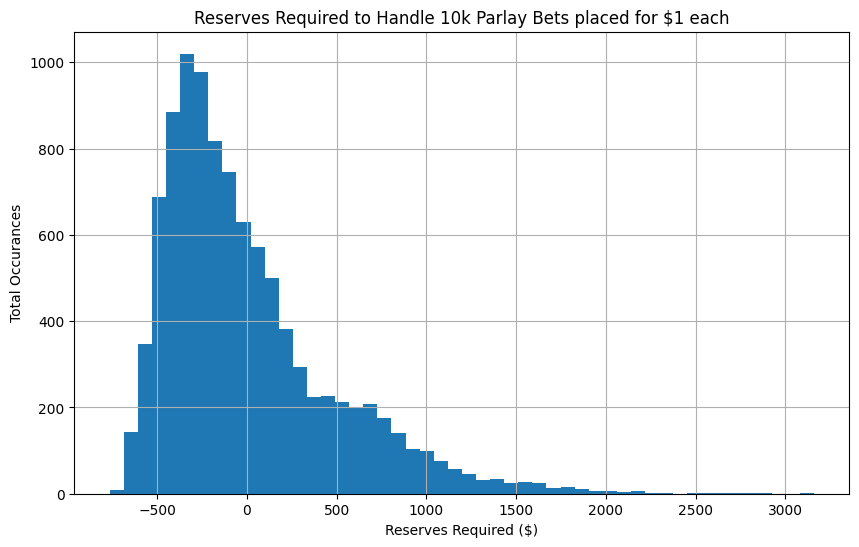

In [41]:
# Convert results to NumPy arrays for easier handling
simulation_total_payouts = np.array(simulation_total_payouts)
simulation_reserves_required = np.array(simulation_reserves_required)
mean_reserves = np.mean(simulation_reserves_required)
# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.hist(simulation_reserves_required,  bins=50)
plt.title('Reserves Required to Handle 10k Parlay Bets placed for $1 each')
plt.xlabel('Reserves Required ($)')
plt.ylabel('Total Occurances')
plt.grid(True)
plt.show()


5.3 Analyzing the Simulation Results

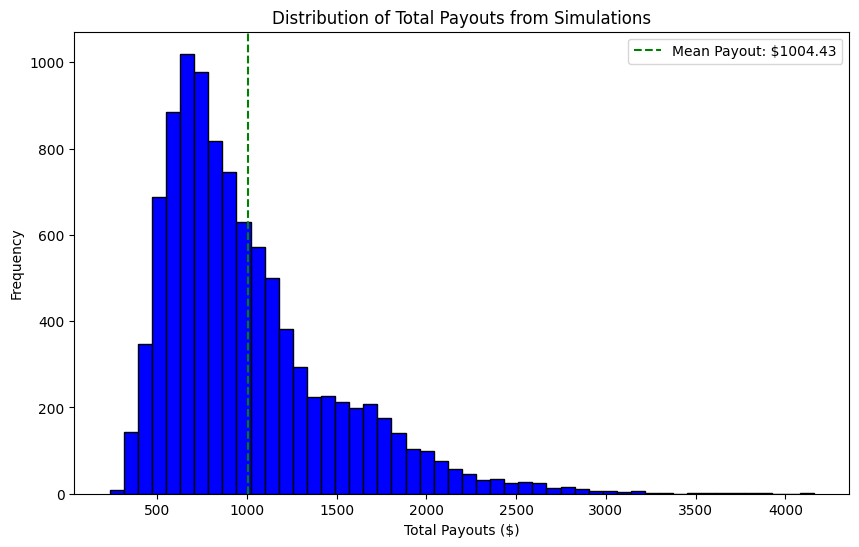

In [20]:
# Plot histogram of total payouts from simulations
mean_payout = np.mean(simulation_total_payouts)
plt.figure(figsize=(10, 6))
plt.hist(simulation_total_payouts, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Total Payouts from Simulations')
plt.xlabel('Total Payouts ($)')
plt.ylabel('Frequency')
plt.axvline(x=mean_payout, color='green', linestyle='--', label=f'Mean Payout: ${mean_payout:.2f}')
plt.legend()
plt.show()


4. Comparing Best, Worst, and Monte Carlo Results
4.1 Displaying Reserves Required

In [21]:
# Calculate total wagers per simulation
total_wagers_simulation = num_bettors * 1.0  # $1 per bettor

# Worst-Case Scenario Reserves Required (from previous calculation)
# Potential payout for each bet in worst-case scenario
potential_payout_worst = 1.0 * (2 ** num_events)  # $1,024 per bet
total_potential_payout_worst = potential_payout_worst * num_bettors
reserves_worst_case = total_potential_payout_worst - total_wagers_simulation

# Best-Case Scenario Reserves Required (from previous calculation)
# This requires re-running the best-case calculations to obtain reserves_best_case
# For simplicity, we can assume reserves_best_case calculated earlier
# Assuming reserves_best_case is available from previous calculations

print(f"Worst-Case Reserves Required (All 10-Leg Parlays): ${reserves_worst_case:,.2f}")
print(f"Average Reserves Required from Simulation: ${np.mean(simulation_reserves_required):,.2f}")
print(f"Maximum Reserves Required from Simulation: ${np.max(simulation_reserves_required):,.2f}")
print(f"Best-Case Reserves Required (All 3-Leg Parlays): ${reserves_best_case:,.2f}")


Worst-Case Reserves Required (All 10-Leg Parlays): $1,023,000.00
Average Reserves Required from Simulation: $4.43
Maximum Reserves Required from Simulation: $3,160.00
Best-Case Reserves Required (All 3-Leg Parlays): $648.00


4.2 Plotting the Comparison

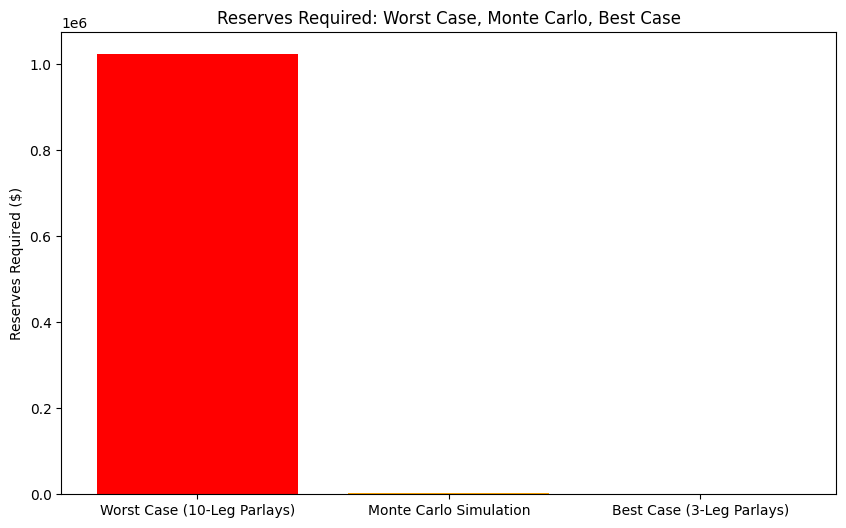

In [25]:
# Bar plot to compare reserves
cases = ['Worst Case (10-Leg Parlays)', 'Monte Carlo Simulation', 'Best Case (3-Leg Parlays)']
reserves = [reserves_worst_case, np.max(simulation_reserves_required), reserves_best_case]

plt.figure(figsize=(10, 6))
plt.bar(cases, reserves, color=['red', 'orange', 'green'])
plt.title('Reserves Required: Worst Case, Monte Carlo, Best Case')
plt.ylabel('Reserves Required ($)')
plt.show()
